In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy
import os

# Adding library directory to python search path
import sys
import git
repo = git.Repo('.', search_parent_directories=True)
library_dir = repo.working_tree_dir + '/lib'
sys.path.insert(0, library_dir)

import miptlib as mipt

# Create directory for generated .tex and .pdf
if not os.path.exists('gen'):
    os.mkdir('gen')

In [28]:
class setup:
    lambda_hg = 5461e-7     # mili meters
    lambda_na = 5893e-7 
    avr_lambda_hg = 5780e-7 # mili meters
    avr_lambda_na = lambda_na
    d_err = 0.002           # mili meters
    d2_err = 2 * d_err      # mili meters
    f_hg = 110              # mili meters
    f_0_hg = 50             # mili meters
    f_na = 94               # mili meters
    
    L = 0.1
    lambda_grn = 5600e-7
    lambda_ylw = 5800e-7
    r = 0.85

In [3]:
data = mipt.read_excel('dat/444.xlsx', usecols=['C', 'G', 'I', 'O', 'Q'], nrows=14).dropna(how='all')
data

,Unnamed: 2,Unnamed: 6,Unnamed: 8,Unnamed: 14,Unnamed: 16
2,155.849,157.823,157.416,169.262,169.437
3,194.612,192.793,193.288,150.432,150.230
4,157.676,159.780,159.450,168.380,168.639
5,192.805,190.461,190.969,151.295,151.075
6,159.610,162.200,161.786,167.309,167.530
7,190.863,187.900,188.545,152.390,152.152
8,161.955,165.409,164.848,166.204,166.402
9,188.446,185.100,185.597,153.500,153.225
10,164.803,170.671,169.441,164.632,164.834
11,185.607,179.743,180.910,155.078,154.800


In [4]:
xsl = {
    "Unnamed: 2" : "grn",
    "Unnamed: 6" : "ylw_in",
    "Unnamed: 8" : "ylw_out",
    "Unnamed: 14" : "n_ylw_in",
    "Unnamed: 16" : "n_ylw_out"
}

data = mipt.map_excel(data, xsl)
data

,grn,ylw_in,ylw_out,n_ylw_in,n_ylw_out
2,155.849,157.823,157.416,169.262,169.437
3,194.612,192.793,193.288,150.432,150.230
4,157.676,159.780,159.450,168.380,168.639
5,192.805,190.461,190.969,151.295,151.075
6,159.610,162.200,161.786,167.309,167.530
7,190.863,187.900,188.545,152.390,152.152
8,161.955,165.409,164.848,166.204,166.402
9,188.446,185.100,185.597,153.500,153.225
10,164.803,170.671,169.441,164.632,164.834
11,185.607,179.743,180.910,155.078,154.800


k_grn, k_grn_err 267.6201933714291 1.0098435827602141


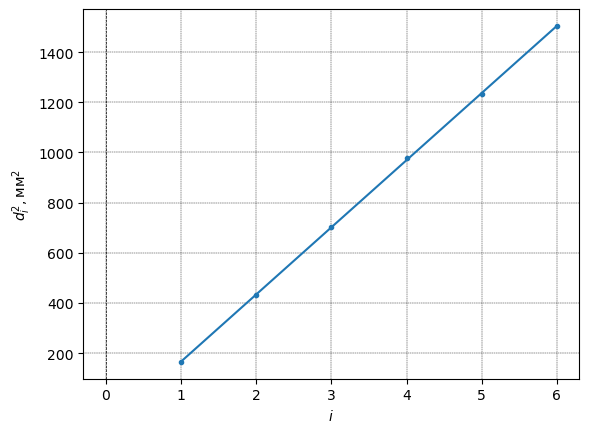

In [5]:
grn = data['grn'].dropna()
d_grn = []
for i in range(len(grn) + 1, 2, -2):
    d_grn.append(grn[i] - grn[i-1])

d_grn2 = np.asarray([ d_grn[i]*d_grn[i] for i in range(len(d_grn)) ])
indexes = np.asarray([ i for i in range(1, len(d_grn2) + 1) ])

mipt.plot(indexes, d_grn2, yerr=setup.d2_err)

mnk_data = mipt.mnk(indexes, d_grn2)
k_grn = mnk_data.get_data()["a"][0]
k_grn_err = mnk_data.get_data()["da"][0]

print("k_grn, k_grn_err", k_grn, k_grn_err)
plt.ylabel(r"$d_i^2, \text{мм}^2$")
plt.xlabel(r"$i$")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.axvline(x = 0, ymin = -1, ymax = 100, color = 'black', linestyle = '--', linewidth = 0.5)

plt.savefig('gen/d2_green.png')
plt.show()

$$\frac{\lambda}{L} = \frac{1}{4f^2}k$$
$$L = \frac{\lambda \cdot 4f^2}{k}$$

In [6]:
L_hg = setup.lambda_hg * 4 * setup.f_hg**2 / k_grn
L_hg_err = L_hg * k_grn_err / k_grn
print("Hg L, L_err in mm", L_hg, L_hg_err)

Hg L, L_err in mm 0.09876399709238749 0.00037267811301919387


In [7]:
ylw_in = data['ylw_in'].dropna()
d_ylw_in = []
for i in range(len(ylw_in) + 1, 2, -2):
    d_ylw_in.append(ylw_in[i] - ylw_in[i-1])

In [8]:
ylw_out = data['ylw_out'].dropna()
d_ylw_out = []
for i in range(len(ylw_out) + 1, 2, -2):
    d_ylw_out.append(ylw_out[i] - ylw_out[i-1])


errors(delta d, 1/d):  0.004 0.000696183816197731
k_ylw, k_ylw_err 30.0611062095773 7.239510204667662


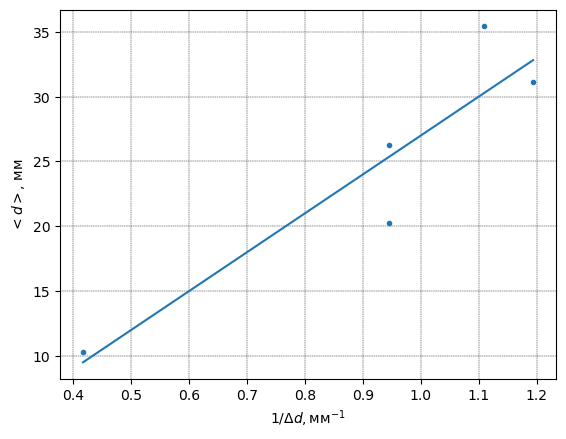

In [9]:
d_avr = np.asarray([ (d_ylw_out[i] + d_ylw_in[i])/2 for i in range(len(d_ylw_in)) ])
rev_delta_d = np.asarray([ 1/(d_ylw_out[i] - d_ylw_in[i]) for i in range(len(d_ylw_in)) ])

# rev_d_err = d_err/d * 1/d
delta_d_err = setup.d_err*2
rev_d_err = delta_d_err * rev_delta_d[0]**2
print("errors(delta d, 1/d): ", delta_d_err, rev_d_err)
mipt.plot(rev_delta_d, d_avr, yerr=delta_d_err, xerr=rev_d_err)

mnk_data_ylw = mipt.mnk(rev_delta_d, d_avr)
k_ylw = mnk_data_ylw.get_data()["a"][0]
k_ylw_err = mnk_data_ylw.get_data()["da"][0]

print("k_ylw, k_ylw_err", k_ylw, k_ylw_err)
plt.ylabel(r"$<d>$, мм")
plt.xlabel(r"$1/\Delta d, \text{мм}^{-1}$")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)

plt.savefig('gen/d_avr_ylw.png')
plt.show()

$$\Delta \lambda = \frac{\lambda <d> \Delta d}{4f^2}$$

$$<d> = \frac{\Delta \lambda 4f^2}{\lambda} \cdot 1/\Delta d$$

$$\Delta \lambda = \frac{\lambda k}{4f^2}$$

In [10]:
delta_lambda = k_ylw * setup.avr_lambda_hg / (4*setup.f_hg**2)
delta_lambda_err = np.sqrt((k_ylw_err / k_ylw * delta_lambda)**2 + delta_lambda**2 * ((delta_d_err/d_avr[0])**2 + (rev_d_err/rev_delta_d[0])**2) )

print("delta lambda, err (in mm)", delta_lambda, delta_lambda_err)

delta lambda, err (in mm) 3.589942022548694e-07 8.645749641220319e-08


## Na:

k_n_ylw_in, k_n_ylw_in_err 65.45101505714297 0.5319500338948071


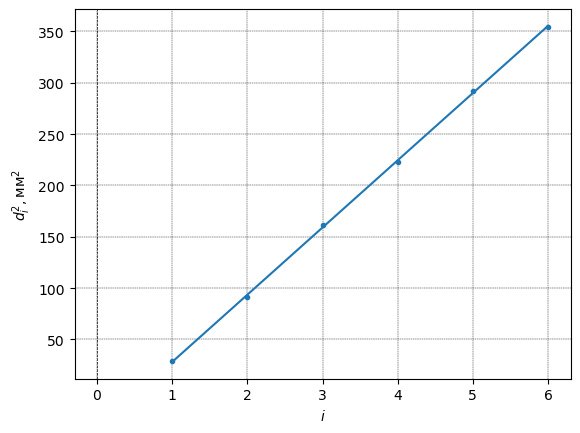

In [11]:
n_ylw_in = data['n_ylw_in'].dropna()
d_n_ylw_in = []
for i in range(len(n_ylw_in) + 1, 2, -2):
    d_n_ylw_in.append(n_ylw_in[i] - n_ylw_in[i-1])

d_n_ylw_in2 = np.asarray([ d_n_ylw_in[i]*d_n_ylw_in[i] for i in range(len(d_n_ylw_in)) ])
indexes = np.asarray([ i for i in range(1, len(d_grn2) + 1) ])

mipt.plot(indexes, d_n_ylw_in2, yerr=setup.d2_err)

mnk_data = mipt.mnk(indexes, d_n_ylw_in2)
k_n_ylw_in = mnk_data.get_data()["a"][0]
k_n_ylw_in_err = mnk_data.get_data()["da"][0]

print("k_n_ylw_in, k_n_ylw_in_err", k_n_ylw_in, k_n_ylw_in_err)
plt.ylabel(r"$d_i^2, \text{мм}^2$")
plt.xlabel(r"$i$")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
plt.axvline(x = 0, ymin = -1, ymax = 100, color = 'black', linestyle = '--', linewidth = 0.5)

plt.savefig('gen/d2_yellow.png')
plt.show()

In [12]:
L_na = setup.lambda_na * 4 * setup.f_na**2 / k_n_ylw_in
L_na_err = L_na * k_n_ylw_in_err / k_n_ylw_in
print("na L, L_err in mm", L_na, L_na_err)

na L, L_err in mm 0.3182260684851964 0.0025863673431056606


#### there we have reversed d1 and d2 in xslx (cause we swapped with partner :))

In [13]:
n_ylw_in = data['n_ylw_in'].dropna()
d_n_ylw_in = []
for i in range(len(n_ylw_in) + 1, 2, -2):
    d_n_ylw_in.append(- n_ylw_in[i] + n_ylw_in[i-1])

In [14]:
n_ylw_out = data['n_ylw_out'].dropna()
d_n_ylw_out = []
for i in range(len(n_ylw_out) + 1, 2, -2):
    d_n_ylw_out.append(- n_ylw_out[i] + n_ylw_out[i-1])

errors(delta d, 1/d):  0.004 0.007092186006762308
k_n_ylw, k_n_ylw_err 10.131549192960955 2.8543693887205084


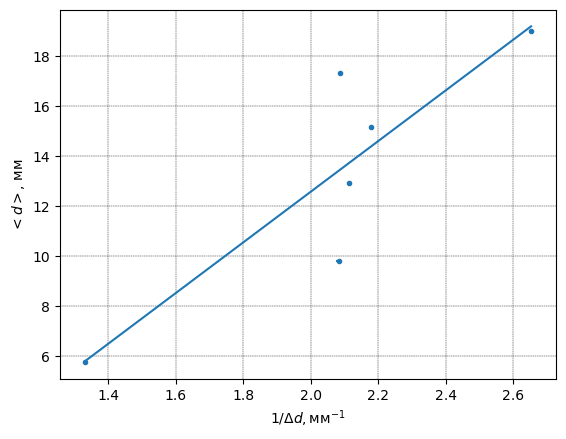

In [15]:
n_d_avr = np.asarray([ (d_n_ylw_out[i] + d_n_ylw_in[i])/2 for i in range(len(d_n_ylw_in)) ])
n_rev_delta_d = np.asarray([ 1/(d_n_ylw_out[i] - d_n_ylw_in[i]) for i in range(len(d_n_ylw_in)) ])

# rev_d_err = d_err/d * 1/d
n_delta_d_err = setup.d_err*2
n_rev_d_err = n_delta_d_err * n_rev_delta_d[0]**2
print("errors(delta d, 1/d): ", n_delta_d_err, n_rev_d_err)
mipt.plot(n_rev_delta_d, n_d_avr, yerr=n_delta_d_err, xerr=n_rev_d_err)

mnk_data_n_ylw = mipt.mnk(n_rev_delta_d, n_d_avr)
k_n_ylw = mnk_data_n_ylw.get_data()["a"][0]
k_n_ylw_err = mnk_data_n_ylw.get_data()["da"][0]

print("k_n_ylw, k_n_ylw_err", k_n_ylw, k_n_ylw_err)
plt.ylabel(r"$<d>$, мм")
plt.xlabel(r"$1/\Delta d, \text{мм}^{-1}$")
plt.grid(color = 'black', linestyle = '--', linewidth = 0.3)
# plt.axvline(x = 0, ymin = -1, ymax = 100, color = 'black', linestyle = '--', linewidth = 0.5)

plt.savefig('gen/d_avr_n_ylw.png')
plt.show()

In [16]:
n_delta_lambda = k_n_ylw * setup.avr_lambda_na / (4*setup.f_na**2)
n_delta_lambda_err = np.sqrt((k_n_ylw_err / k_n_ylw * n_delta_lambda)**2 + n_delta_lambda**2 * ((n_delta_d_err/n_d_avr[0])**2 + (n_rev_d_err/n_rev_delta_d[0])**2) )

print("n_delta lambda, err (in mm)", n_delta_lambda, n_delta_lambda_err)

n_delta lambda, err (in mm) 1.689260394808706e-07 4.760031569656266e-08


In [41]:
# in mm
grn_x1 = 181.665
grn_x2 = 181.139

ylw_x1 = 179.743
ylw_x12 = 170.671
ylw_x2 = 180.91

n_ylw_x1 = 157.114
n_ylw_x12 = 162.501
n_ylw_x2 = 156.785

grn_dr = grn_x1 - grn_x2
ylw_dr = ylw_x2 - ylw_x1
n_ylw_dr = n_ylw_x1 - n_ylw_x2

ylw_avr_r = (ylw_x1 - ylw_x12)/2
n_ylw_avr_r = (n_ylw_x12 - n_ylw_x1)/2

print(grn_dr, ylw_dr, n_ylw_dr)

0.525999999999982 1.1670000000000016 0.32900000000000773


$$D_{\text{эксп}} = \frac{\delta r}{\Delta \lambda} $$

$$D_{\text{теор}} = \frac{f^2}{\lambda \cdot r}$$

In [42]:
d_hg_exp = ylw_dr / delta_lambda
d_hg_exp_err = d_hg_exp * np.sqrt((setup.d_err/ylw_dr)**2 + (delta_lambda_err/delta_lambda)**2)

print("Hg D_exp D_exp_err ", d_hg_exp, d_hg_exp_err)

Hg D_exp D_exp_err  3250748.8774748654 782906.0293636189


In [43]:
d_hg_th = setup.f_hg**2 / (setup.lambda_hg * ylw_avr_r)
d_hg_th_err = d_hg_th * setup.d_err/ylw_avr_r

print("Hg D_th D_th_err ", d_hg_th, d_hg_th_err)

Hg D_th D_th_err  4884725.32664683 2153.758962366326


In [44]:
d_n_exp = n_ylw_dr / n_delta_lambda
d_n_exp_err = d_n_exp * np.sqrt((setup.d_err/n_ylw_dr)**2 + (n_delta_lambda_err/n_delta_lambda)**2)

print("Na D_exp D_exp_err ", d_n_exp, d_n_exp_err)

Na D_exp D_exp_err  1947597.9014902797 548925.7088426283


In [45]:
d_na_th = setup.f_na**2 / (setup.lambda_na * n_ylw_avr_r)
d_na_th_err = d_na_th * setup.d_err/n_ylw_avr_r

print("Hg D_th D_th_err ", d_na_th, d_na_th_err)

Hg D_th D_th_err  5566757.286074781 4133.4748736400825


$$R_{апп} \approx \frac{4f^2}{d\cdot \delta r}$$


In [60]:
# R in meters
R_app_grn   = 4*setup.f_hg**2 / (d_grn[0]*grn_dr)
R_app_ylw   = 4*setup.f_hg**2 / (d_ylw_in[0]*ylw_dr)
R_app_n_ylw = 4*setup.f_na**2 / (d_n_ylw_in[0]*n_ylw_dr)

print(R_app_grn, R_app_ylw, R_app_n_ylw)

7164.061750660112 4571.634106052836 19942.18886737867


$$m = \frac{2L}{\lambda}$$

In [61]:
m_max_grn = 2*setup.L/setup.lambda_grn
m_max_ylw = 2*setup.L/setup.lambda_ylw

print(m_max_grn, m_max_ylw)

357.14285714285717 344.82758620689657


$$R_{\text{апп}} = m\cdot N$$

In [62]:
N_grn = R_app_grn / m_max_grn
N_ylw = R_app_ylw / m_max_ylw
N_n_ylw = R_app_n_ylw / m_max_ylw

print(N_grn, N_ylw, N_n_ylw)

20.059372901848313 13.257738907553223 57.83234771539814


$$R = \frac{\lambda}{\delta \lambda} = \frac{\pi \sqrt{r}}{1 -r}m$$

$$Q = \frac{2\pi L}{\lambda(1 - r)}$$

In [63]:
Q_hg = 2*np.pi*L_hg/(setup.lambda_ylw*(1 - setup.r))
Q_na = 2*np.pi*L_na/(setup.lambda_ylw*(1 - setup.r))

print("Yellow: Q_hg, Q_na", Q_hg, Q_na)

Yellow: Q_hg, Q_na 7132.787303554211 22982.45238928403


In [65]:
N_hg = Q_hg / m_max_ylw
N_na = Q_na / m_max_ylw

print("Yellow: N_hg, N_na", N_hg, N_na)

Yellow: N_hg, N_na 20.68508318030721 66.64911192892369
